In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


In [2]:
file_path = "anime.csv"   
anime_df = pd.read_csv(file_path)


print("=== Dataset Info ===")
print(anime_df.info())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


In [3]:
print("\n=== Missing Values ===")
print(anime_df.isnull().sum())


print("\n=== First 5 Records ===")
display(anime_df.head())


print("\n=== Dataset Shape ===")
print(f"Rows: {anime_df.shape[0]}, Columns: {anime_df.shape[1]}")


=== Missing Values ===
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

=== First 5 Records ===


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



=== Dataset Shape ===
Rows: 12294, Columns: 7


In [7]:
anime_df["episodes"] = pd.to_numeric(anime_df["episodes"], errors="coerce")  
anime_df["episodes"].fillna(anime_df["episodes"].median(), inplace=True)

In [8]:
anime_df["genre"].fillna("Unknown", inplace=True)


anime_df["genre"] = anime_df["genre"].apply(lambda x: x.split(", ") if isinstance(x, str) else [])

In [9]:
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(anime_df["genre"])
genre_df = pd.DataFrame(genre_features, columns=mlb.classes_)


In [10]:
scaler = MinMaxScaler()
num_features = anime_df[["rating", "members", "episodes"]].copy()
num_features.fillna(num_features.median(), inplace=True)  

num_features_scaled = scaler.fit_transform(num_features)
num_df = pd.DataFrame(num_features_scaled, columns=num_features.columns)

In [11]:
feature_df = pd.concat([num_df, genre_df], axis=1)

print("=== Feature Matrix Shape ===")
print(feature_df.shape)

display(feature_df.head())

=== Feature Matrix Shape ===
(12294, 47)


,rating,members,episodes,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
0,0.924370,0.197872,0.000000,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0.911164,0.782770,0.034673,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.909964,0.112689,0.027518,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.900360,0.664325,0.012658,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.899160,0.149186,0.027518,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# --- Compute cosine similarity matrix ---
cosine_sim = cosine_similarity(feature_df, feature_df)

In [13]:
def recommend_anime(title, top_n=10, threshold=0.5):
    if title not in anime_df["name"].values:
        print("❌ Anime not found in dataset.")
        return pd.DataFrame()
    idx = anime_df[anime_df["name"] == title].index[0]
    
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:]
    
    
    sim_scores = [s for s in sim_scores if s[1] >= threshold]
    
    # Get top_n recommendations
    top_indices = [i for i, score in sim_scores[:top_n]]
    top_scores = [score for i, score in sim_scores[:top_n]]
    
    # Prepare result DataFrame
    recommendations = anime_df.iloc[top_indices][["name", "genre", "type", "rating"]].copy()
    recommendations["similarity"] = top_scores
    
    return recommendations.reset_index(drop=True)

In [14]:
target_anime = "Fullmetal Alchemist: Brotherhood"
print(f"\n=== Recommendations for '{target_anime}' ===")
display(recommend_anime(target_anime, top_n=5, threshold=0.3))


=== Recommendations for 'Fullmetal Alchemist: Brotherhood' ===


,name,genre,type,rating,similarity
0,Fullmetal Alchemist,"[Action, Adventure, Comedy, Drama, Fantasy, Ma...",TV,8.33,0.940303
1,Fullmetal Alchemist: The Sacred Star of Milos,"[Action, Adventure, Comedy, Drama, Fantasy, Ma...",Movie,7.50,0.909675
2,Fullmetal Alchemist: Brotherhood Specials,"[Adventure, Drama, Fantasy, Magic, Military, S...",Special,8.11,0.904959
3,Magi: The Labyrinth of Magic,"[Action, Adventure, Fantasy, Magic, Shounen]",TV,8.24,0.858157
4,Magi: The Kingdom of Magic,"[Action, Adventure, Fantasy, Magic, Shounen]",TV,8.50,0.853411



=== Recommendations for 'Fullmetal Alchemist: Brotherhood' ===


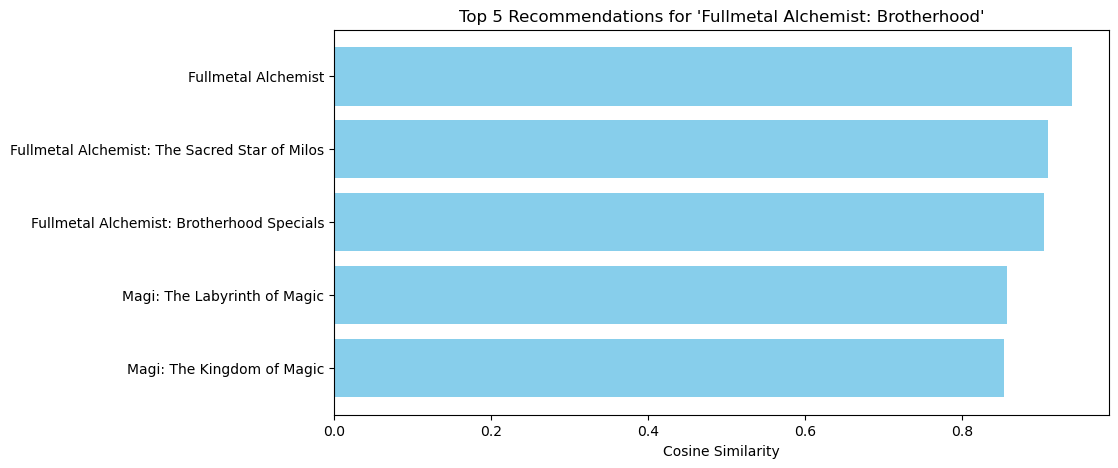

,name,genre,type,rating,similarity
0,Fullmetal Alchemist,"[Action, Adventure, Comedy, Drama, Fantasy, Ma...",TV,8.33,0.940303
1,Fullmetal Alchemist: The Sacred Star of Milos,"[Action, Adventure, Comedy, Drama, Fantasy, Ma...",Movie,7.50,0.909675
2,Fullmetal Alchemist: Brotherhood Specials,"[Adventure, Drama, Fantasy, Magic, Military, S...",Special,8.11,0.904959
3,Magi: The Labyrinth of Magic,"[Action, Adventure, Fantasy, Magic, Shounen]",TV,8.24,0.858157
4,Magi: The Kingdom of Magic,"[Action, Adventure, Fantasy, Magic, Shounen]",TV,8.50,0.853411


In [15]:
# 📌 Step 3: Recommendation System with Visualization

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Compute cosine similarity matrix ---
cosine_sim = cosine_similarity(feature_df, feature_df)

# --- Function to get recommendations with visualization ---
def recommend_anime(title, top_n=10, threshold=0.5, plot=True):
    """
    Recommend similar anime based on cosine similarity.
    
    Parameters:
        title (str): Target anime title
        top_n (int): Number of recommendations
        threshold (float): Minimum similarity score to include
        plot (bool): Whether to plot similarity scores
    
    Returns:
        DataFrame with recommended anime
    """
    if title not in anime_df["name"].values:
        print("❌ Anime not found in dataset.")
        return pd.DataFrame()
    
    # Get index of the target anime
    idx = anime_df[anime_df["name"] == title].index[0]
    
    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort by similarity (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Remove the anime itself (index 0)
    sim_scores = sim_scores[1:]
    
    # Apply threshold
    sim_scores = [s for s in sim_scores if s[1] >= threshold]
    
    # Get top_n recommendations
    top_indices = [i for i, score in sim_scores[:top_n]]
    top_scores = [score for i, score in sim_scores[:top_n]]
    
    # Prepare result DataFrame
    recommendations = anime_df.iloc[top_indices][["name", "genre", "type", "rating"]].copy()
    recommendations["similarity"] = top_scores
    recommendations = recommendations.reset_index(drop=True)
    
    # --- Plot similarity scores ---
    if plot and not recommendations.empty:
        plt.figure(figsize=(10,5))
        plt.barh(recommendations["name"], recommendations["similarity"], color="skyblue")
        plt.gca().invert_yaxis()  # highest similarity on top
        plt.xlabel("Cosine Similarity")
        plt.title(f"Top {top_n} Recommendations for '{title}'")
        plt.show()
    
    return recommendations

# --- Example usage ---
target_anime = "Fullmetal Alchemist: Brotherhood"
print(f"\n=== Recommendations for '{target_anime}' ===")
display(recommend_anime(target_anime, top_n=5, threshold=0.3, plot=True))



=== Evaluation Across Thresholds ===
   Threshold  Precision  Recall  F1-Score
0        0.2          0       0         0
1        0.3          0       0         0
2        0.4          0       0         0
3        0.5          0       0         0
4        0.6          0       0         0


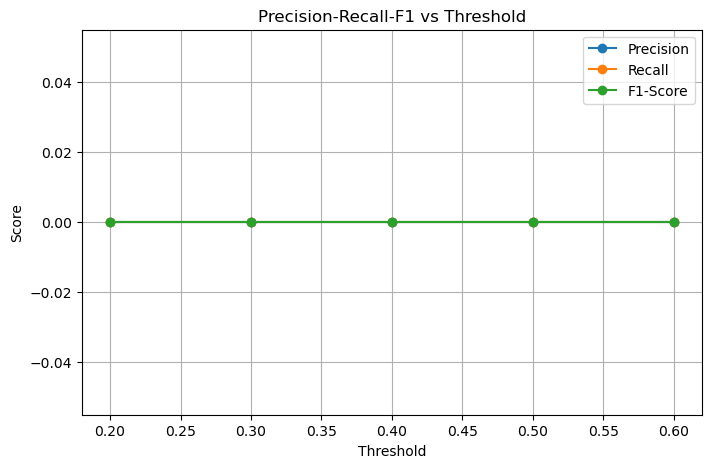

In [18]:
# 📌 Step 4: Evaluation Across Multiple Thresholds

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
results = []

for t in thresholds:
    precision, recall, f1 = evaluate_recommendations(test_df, top_n=5, threshold=t)
    results.append({"Threshold": t, "Precision": precision, "Recall": recall, "F1-Score": f1})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n=== Evaluation Across Thresholds ===")
print(results_df)

# 📊 Plot Precision-Recall Tradeoff
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results_df["Threshold"], results_df["Precision"], marker="o", label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], marker="o", label="Recall")
plt.plot(results_df["Threshold"], results_df["F1-Score"], marker="o", label="F1-Score")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall-F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


Collaborative filtering is one of the most widely used recommendation system techniques that works by leveraging the preferences and behaviors of users to suggest items they might like. Instead of relying on item content or attributes, collaborative filtering is based on the idea that if two users have shown similar interests in the past, they are likely to have similar tastes in the future. It works by analyzing the interactions between users and items, such as ratings, purchases, or clicks, and then identifying patterns to generate personalized recommendations. For example, if a user has liked movies A and B, and another user with similar preferences also liked movie C, then collaborative filtering would recommend movie C to the first user.

There are two main types of collaborative filtering: user-based and item-based. In user-based collaborative filtering, recommendations are made by finding users who are similar to the target user based on their past behaviors and preferences. The system then suggests items that those similar users have liked but the target user has not yet interacted with. For instance, if User X and User Y have both liked five similar movies, and User Y also liked a sixth movie, that sixth movie would be recommended to User X. In contrast, item-based collaborative filtering focuses on the similarity between items rather than users. It identifies items that are often rated or chosen together and recommends similar items to the user. For example, if many users who liked movie A also liked movie B, then movie B would be recommended to a user who liked movie A.

In summary, user-based collaborative filtering emphasizes the similarity between users to make recommendations, while item-based collaborative filtering emphasizes the similarity between items. User-based methods work well when there are many users with shared preferences, while item-based methods are often more scalable and stable because item relationships do not change as frequently as user preferences. Both approaches form the foundation of many recommendation systems used in e-commerce, streaming services, and online platforms.

There are two main types of collaborative filtering: user-based and item-based. In user-based collaborative filtering, the system identifies users with similar behavior to the target user and recommends items that these similar users have liked. For example, on Netflix, if two viewers often watch the same genres or rate the same shows highly, Netflix will recommend titles that one of them has watched but the other has not yet discovered. Similarly, on Spotify, if two listeners frequently enjoy the same artists or playlists, songs liked by one listener may be suggested to the other.

In contrast, item-based collaborative filtering looks at the relationships between items rather than users. The system finds items that are frequently consumed together and recommends them when a user interacts with a similar item. For instance, on Amazon, if many customers who bought a laptop also purchased a specific laptop bag, then that bag is likely to be recommended to someone buying the laptop. Likewise, on YouTube, if users who watch a particular tutorial also often watch a related follow-up video, the system will recommend that follow-up video to new viewers of the first one.